<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a2/ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

#### Show the environment

In [1]:
!nvidia-smi
print()
print()
print('=' * 80)
print()
print()
!df -h
print()
print()
print('=' * 80)
print()
print()
!free -m
print()
print()
print('=' * 80)
print()
print()
!lscpu
print()
print()
print('=' * 80)
print()
print()
! ps -eo pmem,pcpu,vsize,pid,cmd | sort -k 1 -nr | head -5


Sat Apr 24 15:16:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### Setup logging

In [2]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np
import logging
import sys
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
import shutil
import zipfile
import h5py
import gc
import IPython

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

#### Mount Google Drive And Copy Files

In [3]:
drive.mount('/content/gdrive')

if (os.path.exists("/root/imagedata")):
    ret = shutil.rmtree("/root/imagedata")
os.mkdir("/root/imagedata")
shutil.copyfile( \
    "/content/gdrive/MyDrive/DeepLearningAssignment2/earth_data.zip",
    "/root/imagedata/earth_data.zip")

!cd /root/imagedata && unzip earth_data.zip && rm -f earth_data.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Archive:  earth_data.zip
  inflating: earth_data.h5           


## Code to plot graphs and remember histories

In [4]:
class Entry:
    def __init__(self, loss, val_loss, accuracy, val_accuracy, best_accuracy, best_loss):
        self.loss = loss
        self.val_loss = val_loss
        self.accuracy = accuracy
        self.val_accuracy = val_accuracy
        self.best_accuracy = best_accuracy
        self.best_loss = best_loss

class Plot:
    def __init__(self):
        self.history = {}
        self.colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:blue', \
                       'tab:orange', 'tab:green', 'tab:red', 'tab:purple', \
                       'tab:brown', 'tab:pink', 'tab:olive', 'tab:cyan']

    def plot_history(self, history, N_EPOCHS, name, show=True):
        if show:
            N_EPOCHS = len(history.history["loss"])
            plt.rcParams["figure.figsize"] = (20, 10)
            plt.xticks(np.arange(0, N_EPOCHS+1, 1.0))
            plt.plot(np.arange(0, N_EPOCHS), history.history["loss"], label="train loss", color='blue', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_loss"], label="val loss", color='blue', linestyle='dashdot')
            plt.plot(np.arange(0, N_EPOCHS), history.history["accuracy"], label="train acc", color='red', linestyle='solid')
            plt.plot(np.arange(0, N_EPOCHS), history.history["val_accuracy"], label="val acc", color='red', linestyle='dashdot')
            plt.legend()
            plt.show()
        best_val_acc = max(history.history['val_accuracy'])
        index_best_val_accuracy = history.history['val_accuracy'].index(best_val_acc)
        best_val_loss = min(history.history['val_loss'])
        index_best_val_loss = history.history['val_loss'].index(best_val_loss)
        if show:
            print(f"Best validation accuracy: {best_val_acc}, epoch = {index_best_val_accuracy}")
            print(f"Best validation loss: {best_val_loss}, epoch = {index_best_val_loss}")
        entry = Entry(\
                      loss=history.history["loss"],\
                      val_loss=history.history["val_loss"],\
                      accuracy=history.history["accuracy"],\
                      val_accuracy=history.history["val_accuracy"],\
                      best_accuracy=best_val_acc,
                      best_loss=best_val_loss)
        self.history[name] = entry
        gc.collect()

    def superplot(self):
        i = 0
        plt.rcParams["figure.figsize"] = [30, 10]
        fig, ax = plt.subplots(1, 2)
        def innerplot(self, ax, arr, text, linest):
            ax.plot(np.arange(0, len(arr)), arr, label=text, color=self.colors[i], linestyle=linest)
        for name, entry in self.history.items():
            innerplot(self, ax[0], entry.loss, f"{name}-loss", "solid")
            innerplot(self, ax[0], entry.val_loss, f"{name}-val-loss", "dashdot")
            innerplot(self, ax[1], entry.accuracy, f"{name}-accuracy", "solid")
            innerplot(self, ax[1], entry.val_accuracy, f"{name}-val-accuracy", "dashdot")
            i += 1
        ax[0].legend()
        ax[1].legend()
        plt.show()



## Extract train and test instances

In [5]:
def loadDataH5():
    with h5py.File('/root/imagedata/earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
        return trainX, trainY, valX, valY

trainX, trainY, valX, valY = loadDataH5()
trainX = trainX / 255.0
valX = valX / 255.0

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


## Callbacks

In [6]:
def decay_after_runs(N):
    NRUNS = N
    # We're sneaking this in, since this will be called at every epoch
    # it also gives us a good way to force calls to gc() within the fit function
    gc.collect()
    def learning_rate_scheduler(epoch, lr):
        if NRUNS < 0 or epoch < NRUNS:
            return lr
        else:
            print(f"Learning Rate: {lr} --> {lr * tf.math.exp(-1.0)}")
            return lr * tf.math.exp(-0.1)
    return learning_rate_scheduler
lr_callback = tf.keras.callbacks.LearningRateScheduler(decay_after_runs(20))

early_stopping = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=3,
                                                  verbose=1,
                                                  mode='auto')
early_stopping2 = tf.keras.callbacks.EarlyStopping(\
                                                  monitor='val_loss',\
                                                  patience=10,
                                                  verbose=1,
                                                  mode='auto')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(\
                                                 monitor='val_loss',\
                                                 factor=0.5,\
                                                 patience=3,\
                                                 min_lr=0.001)

term_on_nan = tf.keras.callbacks.TerminateOnNaN()

DRIVE_FOLDER = "/content/gdrive/MyDrive/DeepLearningAssignment2"

def get_checkpoint_callback(name):
    checkpoint_filepath = f"{DRIVE_FOLDER}/ckp-{name}"
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback


def get_callbacks_decay_after(N, name=None):
    if N == -2:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(-1)),
                        early_stopping2,
                        term_on_nan,
                        ]
    else:
        callback_array = [\
                        tf.keras.callbacks.LearningRateScheduler(\
                                                    decay_after_runs(N)),
                        early_stopping,
                        term_on_nan,
                        ]
    if N > 0:
        callback_array.append(reduce_lr)
    if None != name:
        callback_array.append(get_checkpoint_callback(name))
    return callback_array

# Question 1 Part A

## 1. Build a model generator

In [7]:
import random
import gc
class ModelFactory:
    @staticmethod
    def get_conv_layer(depth, inshape=None, force_stride_size=False):
        out_layers = []
        filter_size = random.choice([2, 3, 4, 5])
        stride_size = random.choice([1, 2, 3])
        stride_size = stride_size if stride_size < filter_size else filter_size

        # In case there is an exception, the caller will
        # set this and call again
        stride_size = 1 if force_stride_size else stride_size

        stride_size = (stride_size, stride_size, )
        filter_shape = tuple([filter_size, filter_size,])
        act_fn = random.choice(['tanh', 'relu', 'sigmoid', 'selu', 'elu'])
        pd = random.choice(['same', 'valid'])

        if None != inshape:
            conv_layer = tf.keras.layers.Conv2D(\
                                                depth,\
                                                filter_shape,\
                                                padding=pd,\
                                                input_shape=inshape,\
                                                strides=stride_size,\
                                                activation=act_fn)
        else:
            conv_layer = tf.keras.layers.Conv2D(\
                                                depth,\
                                                filter_shape,\
                                                padding=pd,\
                                                strides=stride_size,\
                                                activation=act_fn)
        out_layers.append(conv_layer)

        if random.choice([True, False]):
            pool_size = random.choice([2, 3, 4])
            out_layers.append(tf.keras.layers.MaxPooling2D(\
                                                           pool_size,\
                                                           pool_size,))
        
        if random.choice([True, False]):
            out_layers.append(tf.keras.layers.SpatialDropout2D(0.25))

        return out_layers

    @staticmethod
    def generate_model_internal(inshp, nlabels:int, modelname:str, fss:bool):
        layer_neurons = []
        n_conv_layers = random.choice([1, 2, 3,])
        layer_depth = sorted([\
                random.choice([32, 64, 128, 256, 512, 1024]) \
                    for _ in range(n_conv_layers)])

        for i in range(1, len(layer_depth)):
            if layer_depth[i] <= layer_depth[i-1]:
                layer_depth[i] = 2 * layer_depth[i-1]

        # Add the first Convolutional layer
        model = tf.keras.Sequential(name=modelname)
        for lyr in ModelFactory.get_conv_layer(layer_depth[0], inshp, force_stride_size=fss):
            model.add(lyr)
        
        # Add zero or more additional convoluationa layer
        for d in layer_depth[1:]:
            for lyr in ModelFactory.get_conv_layer(d, inshape=None, force_stride_size=fss):
                model.add(lyr)

        # Flatten
        model.add(tf.keras.layers.Flatten())

        # Add zero or more dense layers
        n_dense = random.choice([0, 1, 2])
        for _ in range(n_dense - 1):
            act_fn = random.choice(['tanh', 'relu', 'sigmoid', 'selu', 'elu'])
            layer = tf.keras.layers.Dense(\
                                random.choice([32, 64, 128, 256, 512]),
                                activation=act_fn)
            model.add(layer)
            if random.choice([True, False]):
                layer = tf.keras.layers.Dropout(0.25)
                model.add(layer)
        
        # Add the final Dense layer
        model.add(tf.keras.layers.Dense(nlabels, activation='softmax'))
        
        return model

    @staticmethod
    def print_model(model):
        plot = tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True)
        IPython.display.display(plot)
        print(model.summary())

    @staticmethod
    def generate_model_size(inshp:tuple, nlabels:int, modelname:str, max_params:int):
        if (-1 == max_params):
            try:
                model = ModelFactory.generate_model_internal(\
                                                            inshp,\
                                                            nlabels,\
                                                            modelname,\
                                                            False)
            except:
                model = ModelFactory.generate_model_internal(\
                                                            inshp,\
                                                            nlabels,\
                                                            modelname,\
                                                            True)
            ModelFactory.print_model(model)
            return model
        else:
            # Make 10 attempts to generate a model with the number of
            # trainable params less than the one specified
            for i in range(10):
                gc.collect()
                logging.debug(f"Attempt {i}")
                try:
                    model = ModelFactory.generate_model_internal(\
                                                                inshp,\
                                                                nlabels,\
                                                                modelname,
                                                                False)
                except:
                    model = ModelFactory.generate_model_internal(\
                                                                inshp,\
                                                                nlabels,\
                                                                modelname,
                                                                True)
                if model.count_params() < max_params:
                    ModelFactory.print_model(model)
                    gc.collect()
                    return model

                gc.collect()
            return None
    
    @staticmethod
    def generate_model(inshp:tuple, nlabels:int, modelname:str, max_params:int):
        """
        Tries to make a model with the number of trainable params less
        than the specified number. If it is not able to do so, it will
        create a model with a greater number regardless
        """
        model = ModelFactory.generate_model_size(\
                                                 inshp,\
                                                 nlabels,\
                                                 modelname,\
                                                 max_params)
        if None == model:
            model = ModelFactory.generate_model_size(\
                                                     inshp,\
                                                     nlabels,\
                                                     modelname,\
                                                     -1)
        return model

# Generate the Base Models

In [8]:

def get_formatted_json(jsonstr):
    j = json.loads(jsonstr)
    return json.dumps(j, indent=4)

get_model_name = lambda n : f"ensemble-base-model-{n}"
get_model_json_filename = lambda n : f"save-ensemble-base-model-{n}.json"

import json
def generate_base_models(n_models):
    n_classes = len(np.unique(np.concatenate((trainY, valY))))
    for i in range(n_models):
        modelname = get_model_name(i)
        filename = get_model_json_filename(i)
        model = ModelFactory.generate_model(trainX[0].shape, n_classes, modelname, 9_500_000)
        model_json = model.to_json()
        with open(f"{DRIVE_FOLDER}/{filename}", "w") as f:
            f.write(get_formatted_json(model_json))
            f.close()

# Train each model

In [9]:
def train_model_internal(model, plot):
    print(model.summary())
    print()
    N_EPOCHS = 2
    model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
    if model.count_params() < 1_500_000:
        print("Using decay of learning reate")
        cb = get_callbacks_decay_after(5, model.name)
    else:
        print("Avoiding decay of learning reate")
        cb = get_callbacks_decay_after(-1, model.name)
    history = model.fit(trainX, trainY, \
                    validation_data=(valX, valY),\
                    batch_size=32,\
                    epochs=N_EPOCHS,
                    callbacks=cb)
    if plot:
        plot.plot_history(history, 100, model.name)

def train_model(i, plot):
    print('=' * 80)
    print('=' * 80)
    print(f"Training model {i}")
    print()
    fname = get_model_json_filename(i)
    fname = f"{DRIVE_FOLDER}/{fname}"
    with open(fname, "r") as f:
        jsonstr = f.read()
        model = tf.keras.models.model_from_json(jsonstr)
        train_model_internal(model, plot)

In [10]:
def load_model(n):
    fname = get_model_json_filename(n)
    fname = f"{DRIVE_FOLDER}/{fname}"
    with open(fname, "r") as f:
        jsonstr = f.read()
        model = tf.keras.models.model_from_json(jsonstr)
        model.compile(optimizer='adam', \
              loss='sparse_categorical_crossentropy', \
              metrics=['accuracy'])
    return model

def load_model_weight(model, n):
    weight_file = f"{DRIVE_FOLDER}/ckp-{model.name}"
    model.load_weights(weight_file)

In [11]:
N_BASE_MODELS = 10
def main():
    plot = Plot()
    #generate_base_models(N_BASE_MODELS)
    for i in range(N_BASE_MODELS):
        train_model(i, plot)
    for i in range(N_BASE_MODELS):
        model = load_model(i)
        loss, acc = model.evaluate(valX, valY, verbose=0)
        print(f"{i}       {loss}        {acc}")
        load_model_weight(model, i)
        loss, acc = model.evaluate(valX, valY, verbose=0)
        print(f"{i}       {loss}        {acc}")
        print()
    plot.superplot()

Training model 0

Model: "ensemble-base-model-0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 20, 20, 32)        2432      
_________________________________________________________________
spatial_dropout2d_23 (Spatia (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 10, 10, 256)       33024     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 2, 2, 256)         0         
_________________________________________________________________
spatial_dropout2d_24 (Spatia (None, 2, 2, 256)         0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_27 (Dense)           

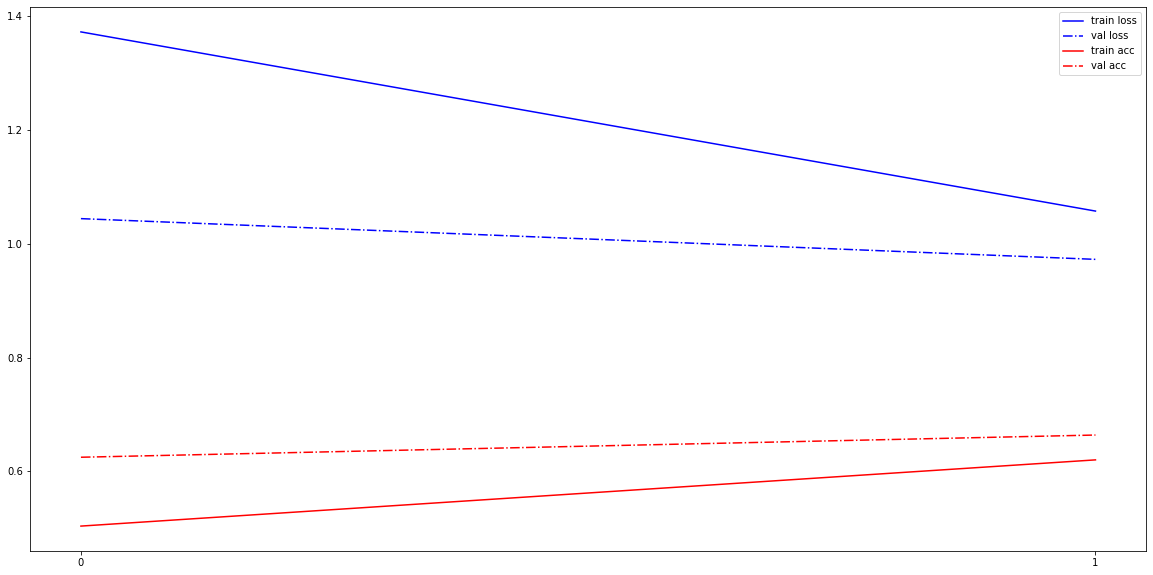

Best validation accuracy: 0.6639583110809326, epoch = 1
Best validation loss: 0.9722550511360168, epoch = 1
Training model 1

Model: "ensemble-base-model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 63, 63, 256)       3328      
_________________________________________________________________
spatial_dropout2d_30 (Spatia (None, 63, 63, 256)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 63, 63, 1024)      2360320   
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 1024)      0         
_________________________________________________________________
spatial_dropout2d_31 (Spatia (None, 15, 15, 1024)      0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 230400)        

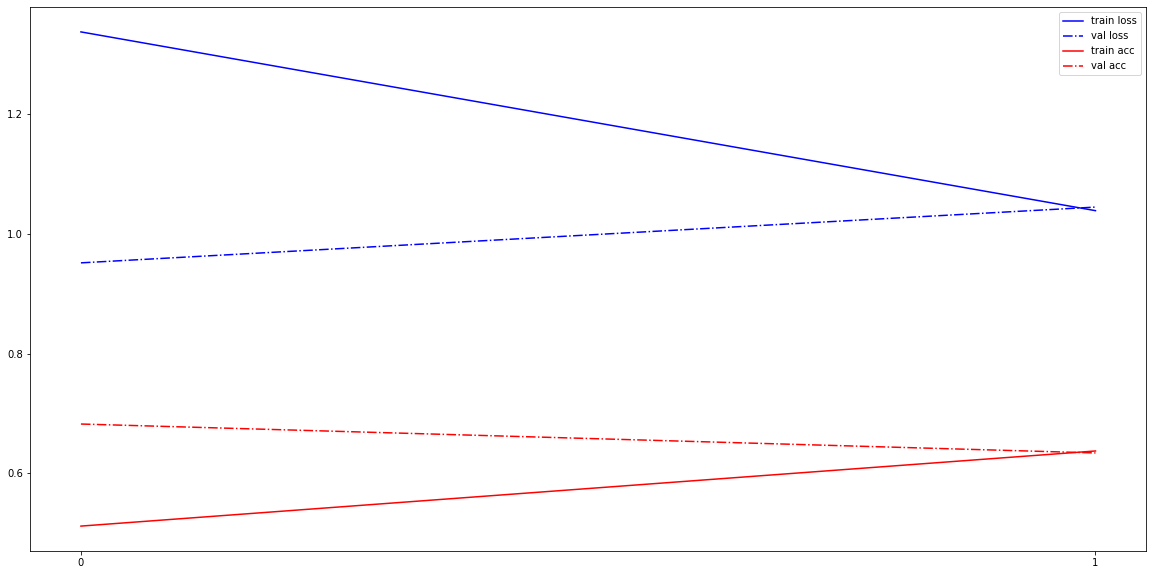

Best validation accuracy: 0.6825000047683716, epoch = 0
Best validation loss: 0.9519248604774475, epoch = 0
Training model 2

Model: "ensemble-base-model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 22, 22, 32)        896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 32)          0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 3, 3, 512)         66048     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 512)         0         
_________________________________________________________________
spatial_dropout2d_35 (Spatia (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 512)           

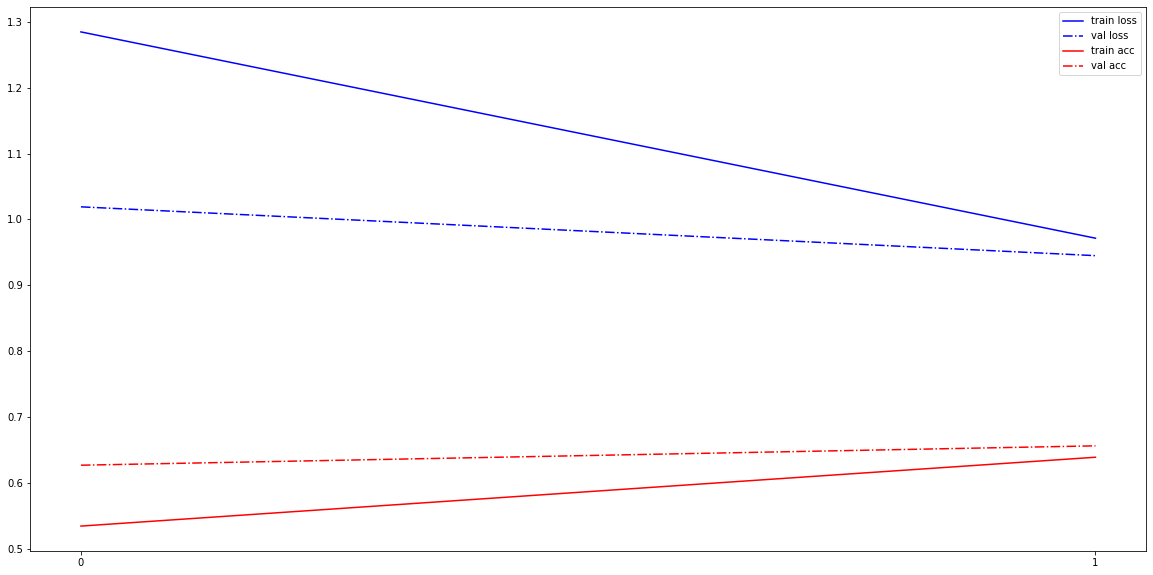

Best validation accuracy: 0.65645831823349, epoch = 1
Best validation loss: 0.9450294971466064, epoch = 1
Training model 3

Model: "ensemble-base-model-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 32, 32, 128)       1664      
_________________________________________________________________
spatial_dropout2d_36 (Spatia (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_34 (Dense)             (None, 9)                 1179657   
Total params: 1,181,321
Trainable params: 1,181,321
Non-trainable params: 0
_________________________________________________________________
None

Using decay of learning reate
Epoch 1/2
600/600 [==============================] - 4s 6ms/step - loss: 

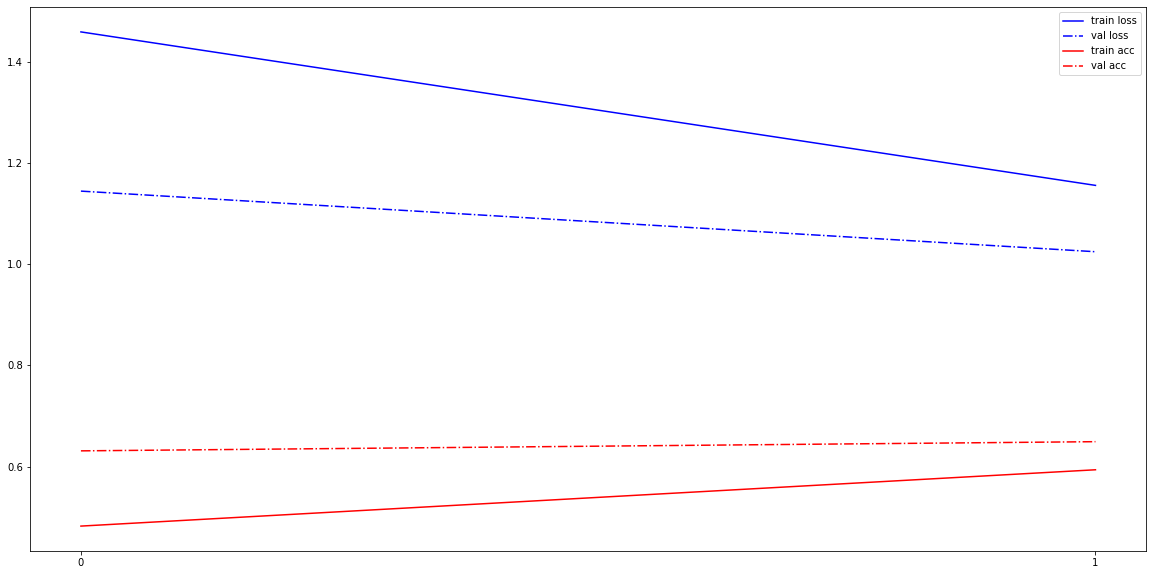

Best validation accuracy: 0.6495833396911621, epoch = 1
Best validation loss: 1.0246021747589111, epoch = 1
Training model 4

Model: "ensemble-base-model-4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 21, 21, 128)       3584      
_________________________________________________________________
flatten_24 (Flatten)         (None, 56448)             0         
_________________________________________________________________
dense_35 (Dense)             (None, 9)                 508041    
Total params: 511,625
Trainable params: 511,625
Non-trainable params: 0
_________________________________________________________________
None

Using decay of learning reate
Epoch 1/2
600/600 [==============================] - 3s 4ms/step - loss: 7.8608 - accuracy: 0.1796 - val_loss: 2.3221 - val_accuracy: 0.3069
Epoch 2/2
600/600 [==============================] - 2s 4ms/step -

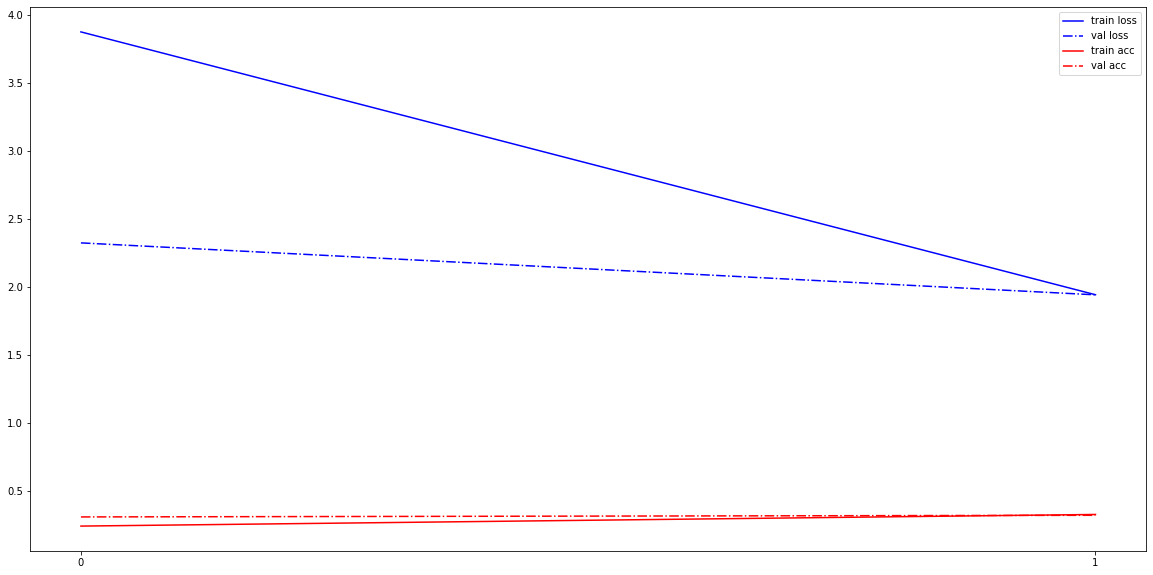

Best validation accuracy: 0.3189583420753479, epoch = 1
Best validation loss: 1.940147042274475, epoch = 1
Training model 5

Model: "ensemble-base-model-5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 31, 31, 32)        1568      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
spatial_dropout2d_37 (Spatia (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 4, 4, 64)          32832     
_________________________________________________________________
spatial_dropout2d_38 (Spatia (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 1024)           

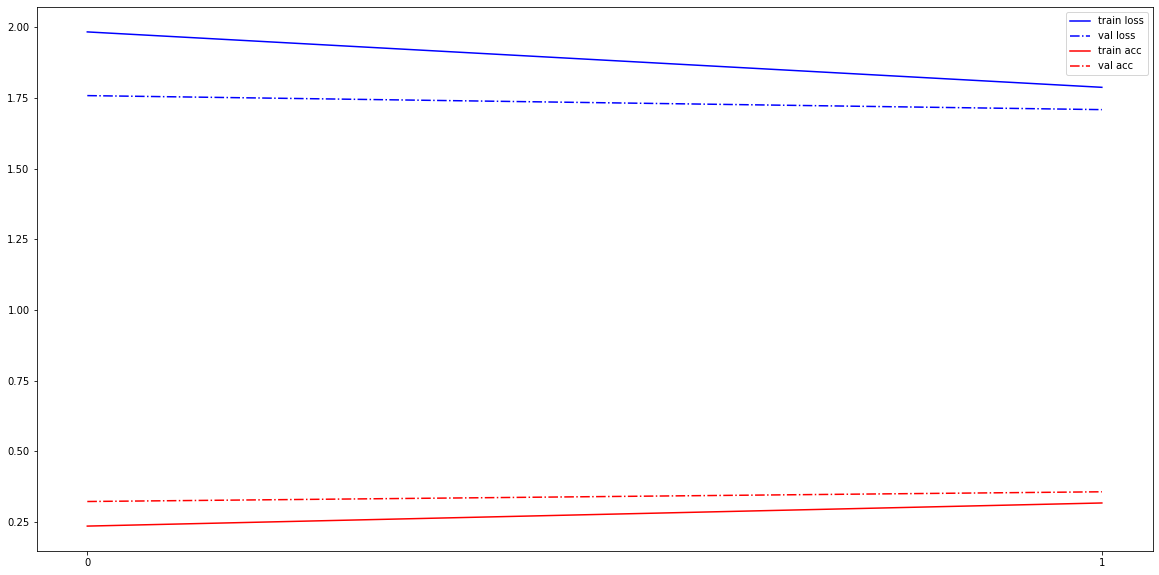

Best validation accuracy: 0.35624998807907104, epoch = 1
Best validation loss: 1.7083550691604614, epoch = 1
Training model 6

Model: "ensemble-base-model-6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 22, 22, 32)        1568      
_________________________________________________________________
spatial_dropout2d_40 (Spatia (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 22, 22, 256)       73984     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 3, 3, 1024)        2360320   
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 1, 1, 1024)   

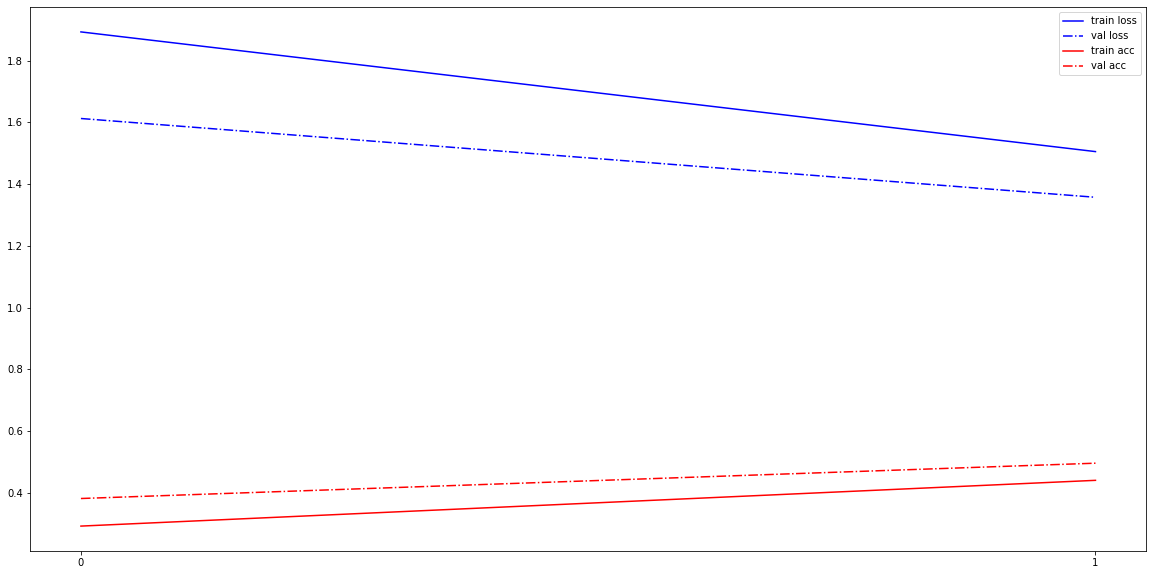

Best validation accuracy: 0.4960416555404663, epoch = 1
Best validation loss: 1.3571052551269531, epoch = 1
Training model 7

Model: "ensemble-base-model-7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 61, 61, 32)        1568      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
spatial_dropout2d_43 (Spatia (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 15, 15, 128)       65664     
_________________________________________________________________
spatial_dropout2d_44 (Spatia (None, 15, 15, 128)       0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 28800)         

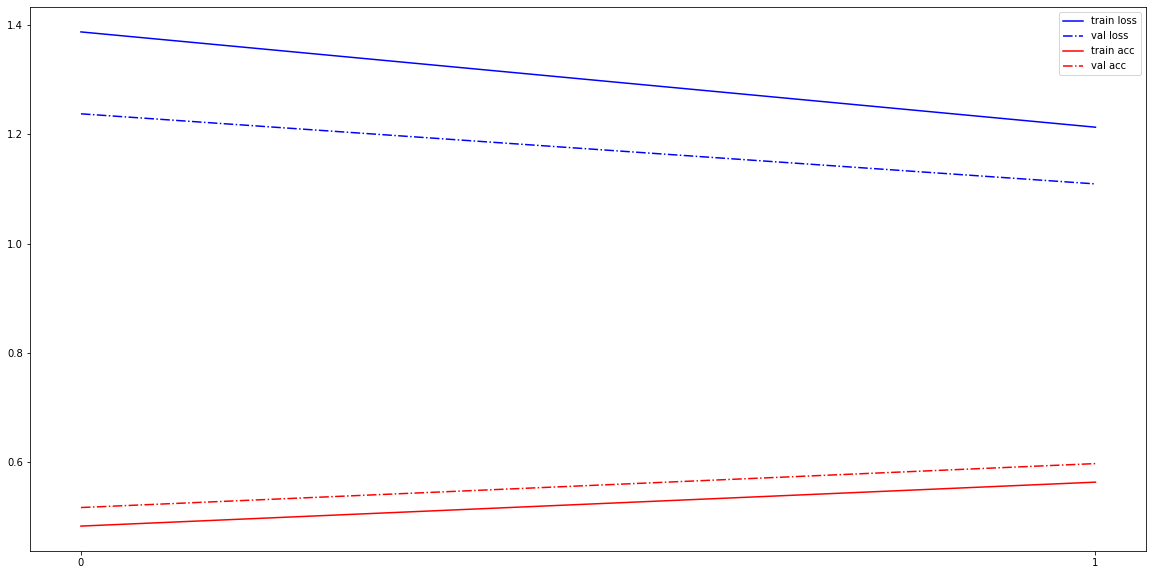

Best validation accuracy: 0.5977083444595337, epoch = 1
Best validation loss: 1.1094468832015991, epoch = 1
Training model 8

Model: "ensemble-base-model-8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 64, 64, 32)        2432      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 7, 7, 512)         262656    
_________________________________________________________________
flatten_32 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_48 (Dense)             (None, 9)                 225801    
Total params: 490,889
Trainable params: 490,889
Non-trainable params: 0
_____________________________________________

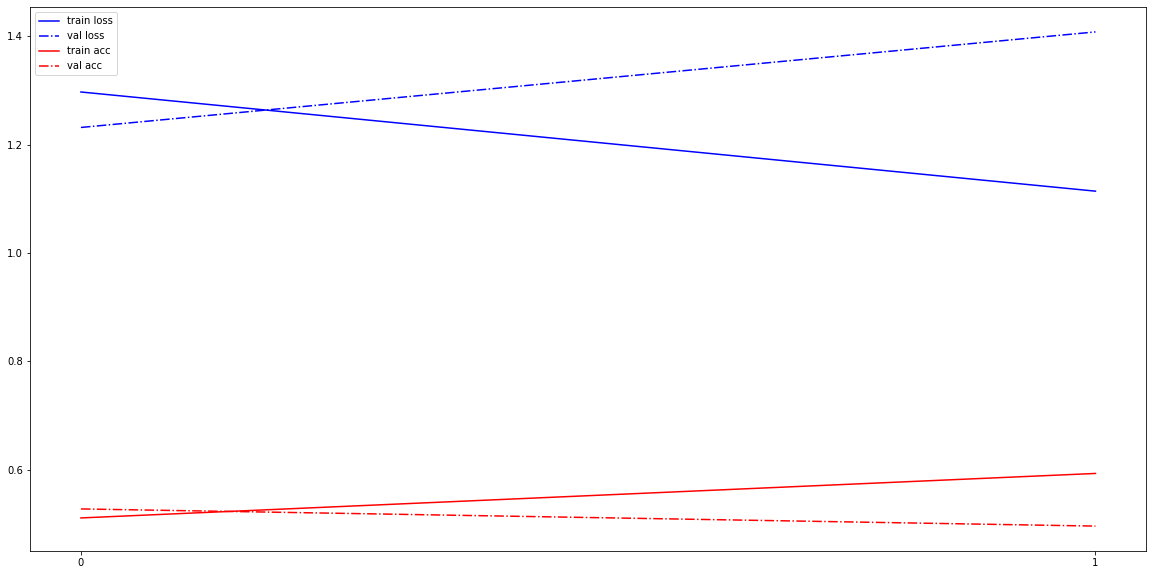

Best validation accuracy: 0.527916669845581, epoch = 0
Best validation loss: 1.2317535877227783, epoch = 0
Training model 9

Model: "ensemble-base-model-9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 32, 32, 128)       1664      
_________________________________________________________________
spatial_dropout2d_45 (Spatia (None, 32, 32, 128)       0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 131072)            0         
_________________________________________________________________
dense_49 (Dense)             (None, 9)                 1179657   
Total params: 1,181,321
Trainable params: 1,181,321
Non-trainable params: 0
_________________________________________________________________
None

Using decay of learning reate
Epoch 1/2
600/600 [==============================] - 4s 6ms/step - loss:

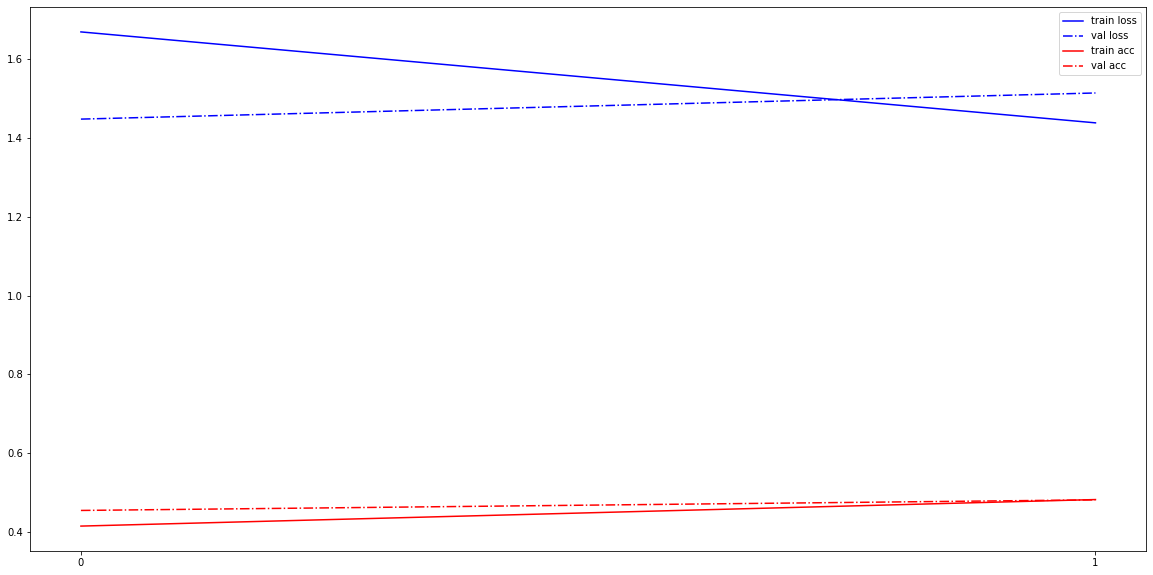

Best validation accuracy: 0.48124998807907104, epoch = 1
Best validation loss: 1.448274850845337, epoch = 0
0       2.2133142948150635        0.10437499731779099
0       0.9722550511360168        0.6639583110809326

1       2.194413900375366        0.13187499344348907
1       0.9519248604774475        0.6825000047683716

2       2.19834303855896        0.10645833611488342
2       0.9450294971466064        0.65645831823349

3       2.2041895389556885        0.12604166567325592
3       1.0246021747589111        0.6495833396911621

4       2.4492249488830566        0.1041666641831398
4       1.940147042274475        0.3189583420753479

2021-04-24 15:22:03,722 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.beta_1
2021-04-24 15:22:03,726 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.beta_2
2021-04-24 15:22:03,729 - tensorflow - WARNING - Unresolved object in checkpoint: (root).optimizer.decay
2021-04-24 15:22:03,733 - tensorflow - WAR

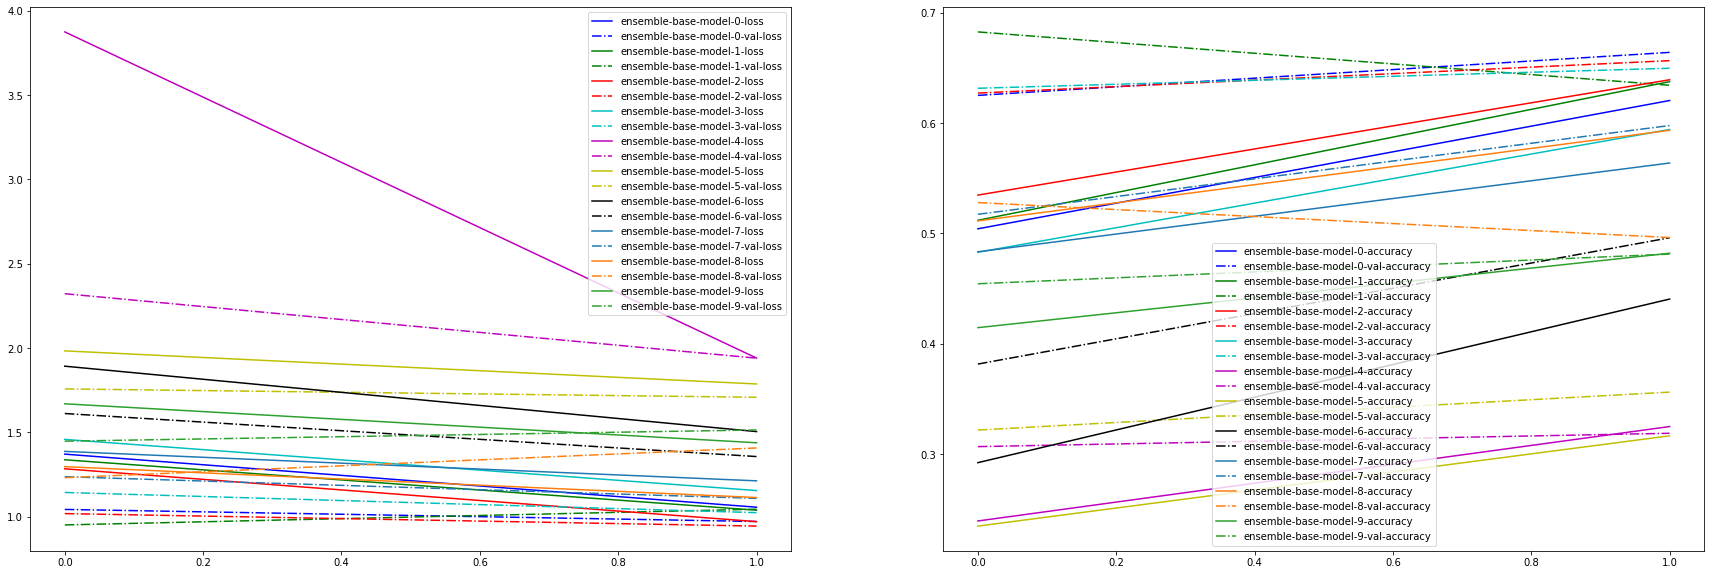

In [12]:
main()